In [1]:
from gurobipy import *
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import pandas as pd
import random as rd
import time
import math
from scipy.optimize import curve_fit 

# Generate graphs with different generate models

In [92]:
# Define the number fo vertices
vertex_number = 50

In [93]:
%%time
# BA model
# This model simulates behaviors in social networks, 
# nodes with higher degree (popular) are more likely to link to others.
# Degree distribution of it follow power-law(Pareto) distribution, 
# which means only little amount of nodes have large degrees.
# Thus kenerlization is a good strategy.

Graph_BA = nx.barabasi_albert_graph(vertex_number, m=9, seed=8787)
Graph_BA.name = 'BA'

Wall time: 1 ms


In [95]:
%%time

# ER model
# Randomly connect node pairs by iid Bernulli(p)
# It's decentralized since all node are mutually symmetric, 
# thus kernalization algorithm fail to solve it efficiently.
# But since it is quite dense, finding large clique in it might be good 
# Generally, finding minium vertex cover in these graph are more challenging.

Graph_ER = nx.gnp_random_graph(vertex_number, p=0.08, seed=8787)
Graph_ER.name = 'ER'

Wall time: 3 ms


# Greedy

In [7]:
def argmax_degree(graph):
    return max(graph.degree, key=lambda x: x[1])[0]

def greedy(G):
    """Add the node with largest degree into vertex cover."""
    G2 = G.copy()
    cover_size = 0
    while G2.size():
        G2.remove_node(argmax_degree(G2))
        cover_size += 1
        
    return cover_size

# $1+\epsilon$  Approximate algorithm

In [8]:
def maximal_clique(graph, node, among_k=None):
    H = nx.ego_graph(graph, node)
    if among_k != None:  # maximal clique among k
        maximals = nx.find_cliques(H)
        return max( (clq for clq, _ in zip(maximals, range(among_k))), key=len)
    else:  # maximum clique
        return max(nx.find_cliques(H), key=len)

def two_approximate(G):
    """ Select a matching. Add both end point into vertex cover.
    with maximal matching k, minimum vertex cover is in [k, 2k].
    Note: maximum matching is the weak dual problem to minimum vertex cover.
        And the strong dual to minimum vertex cover of bipartites."""
    k = len(nx.maximal_matching(G))
    return k, 2*k

def two_approximate_nodes(graph):
    """ Select a matching. Add both end point into vertex cover and remove them from graph.
    with maximal matching k, minimum vertex cover must in [k, 2k].
    
    Note: maximum matching is the dual problem (weak) to minimum vertex cover.
        And it's strong dual to minimum vertex cover of bipartite. """
    
    return [ v for e in nx.algorithms.matching.maximal_matching(graph) for v in e ]

def two_minus_approximate(G, among_k=None, simplify=None):
    """Think match as independent 2-cliques, promote `2-approximate` by finding big cliques (randomly/greedily)
    Note: A n-clique require at least n-1 node to cover it.
        For example, if k triangles (3-clique) covers,
        then minimum vertex cover is in [2k, 3k]. (1.5-approximate) """
    lower_bound, cover_size = 0, 0
    while G.size():
        clique = maximal_clique(G, argmax_degree(G), among_k)
        lower_bound += len(clique) - 1
        cover_size += len(clique)
        G.remove_nodes_from(clique)
        
        if simplify != None:
            trivial_solution, G = simplify(G)
            cover_size += trivial_solution

    return lower_bound, cover_size

# Simplify & kernelize

In [9]:
def kernels_inferiors(G, k):
    kernels, inferiors, isolates = [], [], []
    for u, deg in G.degree:
        if deg > k: # must select vertex with degree > k
            kernels.append(u)
        elif deg == 1: # leaves are inferior choices
            inferiors.append(u)
        elif deg == 0:
            isolates.append(u)
    G.remove_nodes_from(isolates)
    return kernels, inferiors

def kernelize_and_simplify(G, k):
    """Vertify if there exist a cover with size k or less."""
    num = k # cover G with `num` or less nodes
    kernels, inferiors = kernels_inferiors(G, num)

    while kernels or inferiors:
        if len(kernels) > num: # Fail to cover 
            return -1, -1, None
        # remove kernels
        G.remove_nodes_from(kernels)
        num -= len(kernels)

        # remove superiors
        for inf in inferiors:
            if ( inf in G ) and ( G.degree[inf] == 1 ): # superior not removed yet
                G.remove_node( next(G.neighbors(inf)) )
                num -= 1
        
        if num < 0:
            return -1, -1, None
        
        kernels, inferiors = kernels_inferiors(G, num)
        
    G.remove_nodes_from( list(nx.isolates(G)) )
    
    if ( G.size() > num**2 ) or ( G.order() > num*(num+1) ): # consider number of components?
        return -1, -1, None
    return k-num, num, G   # find `num` more nodes that covers G'

# Bounded Search algorithm (FPT)

In [10]:
def trivial_case(G, k):
    if G.size() <= k: 
        return 2 * len(nx.maximal_matching(G))
    elif G.order() <= 3:
        minimum = ( G.size() + 1 ) // 2
        return minimum if k >= minimum else -1
    else:
        return k

In [74]:
def bounded_search(G, k, n, start, among_k=None, dp_dict=None, a=2):
    end = time.time()
    if (end-start) > a*n and (end-start) > 100:
        return -1
    
    # trivial cases
    t = trivial_case(G, k)
    if t < 0:
        return t
    
    # simplification
    found, num, G = kernelize_and_simplify(G, k) # find `num` more covers in G'
    if num < 0:
        return -1
    elif G.size() == 0:
        return found
    
    #=== Reduce into smaller graph by finding a large clique in it ===
    
    # find a n-clique in graph, n-1 one them must be selected
    clique = maximal_clique(G, argmax_degree(G), among_k)
    num -= (len(clique) - 1)
    found += (len(clique) -1)
    if num < 0:
        return -1
    between = dict()
    for u, v in nx.edge_boundary(G, clique):
        if u in between:
            between[u].append(v)
        else:
            between[u] = [v]
        
    G.remove_nodes_from(clique) # remove them all first, add them back later
    G.remove_nodes_from(list(nx.isolates(G)))
    
    for u, vs in between.items(): # add one back
        G.add_star( [u] + vs )
        res = bounded_search(G.copy(), num, n, start)
        if res >= 0:
            return res + found
        G.remove_node(u)
    else:
        return -1

In [12]:
def downward_search(graph, k, n, among_k=None):
    start = time.time()
    while True:
        G = graph.copy()
        res = bounded_search(G, k-1, n, start, among_k)
        if res < 0:
            return k
        
        k = res

In [13]:
for G in [ Graph_ER, Graph_BA ]:
    n = G.number_of_nodes()
    print(f'\n=== {G.name} ===')
    
    Gc = G.copy()
    %time k = greedy(Gc); print(f'\nGreedy minimal = {k}')
    Gc = G.copy()
    %time print('\n2-Approximate [%d, %d]'%two_approximate(Gc))
    Gc = G.copy()
    %time print('\nk-Approximate [%d, %d]'%two_minus_approximate(Gc) )
    Gc = G.copy()
    %time print(f'\nbound search minimum = {downward_search(Gc, k, n)}' )


=== ER ===

Greedy minimal = 9
Wall time: 0 ns

2-Approximate [8, 16]
Wall time: 0 ns

k-Approximate [6, 12]
Wall time: 1 ms

bound search minimum = 8
Wall time: 0 ns

=== BA ===

Greedy minimal = 9
Wall time: 1 ms

2-Approximate [9, 18]
Wall time: 4 ms

k-Approximate [11, 15]
Wall time: 3 ms

bound search minimum = 11
Wall time: 0 ns


# Modeling

In [14]:
def setup_VC_matrix(data):    # data is a symmetric matrix which representing a vertex covering problem graph.
    model = Model("VC")
    n = data.shape[0]
    v = {}
    
    for i in range(0, n):
        v[i] = model.addVar(vtype="B", name="v(%s)"%i)    # vertex(i)
    model.update()
    
    for i in range(1, n):
        for j in range(0, i):
            if data[i][j] == 1: model.addConstr( v[i] + v[j] >= 1 )
    model.update()
    
    model.setObjective(quicksum(v[i] for i in range(0, n)) , GRB.MINIMIZE)
    model.update()             
    return model

In [15]:
def setup_VC_networkx(data):    # data is a Graph (generated by networkx)
    model = Model("VC")
    n = data.number_of_nodes()
    edge_list = list(data.edges)
    v = {}
    
    for i in range(0, n):
        v[i] = model.addVar(vtype="B", name="v(%s)"%i)    # vertex(i)
    model.update()
    
    for pair in edge_list:
        i = pair[0]
        j = pair[1]
        model.addConstr( v[i] + v[j] >= 1 )
    model.update()
    
    model.setObjective(quicksum(v[i] for i in range(0, n)) , GRB.MINIMIZE)
    model.update()             
    return model

In [16]:
# list of Optimal solution
def solution_list_from_gurobi(getVars):    # input _.getVars() only !
    sol_list = []
    for v in getVars:
        if v.x > 0:
            name = list(v.varName)
            name.remove('v')
            name.remove('(')
            name.remove(')')
            sol_list.append(int(''.join(name)))

    return sol_list

# Integrated class with Ploting

In [102]:
class Vertex_Cover_Problem:    
    
    def __init__(self, data):                       # data is a Graph object generate by networkx function.
        self.data = data
        self.pin_position = nx.spring_layout(data)
        self.figsize = [80, 80]                     # We might need to adjust this value according to the number of vertices.
        
        self.two_approximate_edges = []
        self.two_approximate_nodes = []
        
        self.solution_greedy = 'Please use .do_greedy to obtain the optimal solution value.'
        self.solution_two_approximate = 'Please use .do_two_approximate to obtain the optimal solution value.'
        self.solution_two_minus_approximate = 'Please use .do_two_minus_approximate to obtain the optimal solution value.'
        self.solution_bounded_search = 'Please use .do_bounded_search to obtain the optimal solution value.'
        self.solution_optimal = 'Please use .do_solve_modeling to obtain the optimal solution value.'
        self.Optimal_solution_list  = []
        
        self.runtime_greedy = 'Please use .do_greedy to obtain its runtime.'
        self.runtime_two_approximate = 'Please use .do_two_approximate to obtain its runtime.'
        self.runtime_two_minus_approximate = 'Please use .do_two_minus_approximate to obtain its runtime.'
        self.runtime_bounded_search = 'Please use .do_bounded_search to obtain its runtime.'
        self.runtime_optimal = 'Please use .do_solve_modeling to obtain its runtime.'
    
    # solve
    #########       
    def do_greedy(self):
        self.solution_greedy = greedy(self.data)
        print('greedy search finished')
        
    def do_two_approximate(self):
        self.two_approximate_edges    = list(nx.algorithms.matching.maximal_matching(self.data))
        self.two_approximate_nodes    = two_approximate_nodes(self.data)
        self.solution_two_approximate = two_approximate(self.data)
        print('two approximate finished')
    
    def do_two_minus_approximate(self):
        G = self.data.copy()
        self.solution_two_minus_approximate = two_minus_approximate(G)
        print('two minus approximate finished')
        
    def do_bounded_search(self):
        n = self.data.number_of_nodes()
        G = self.data.copy()
        k = greedy(G)
        self.solution_bounded_search = downward_search(G, k, n)
        print('Bounded Search finished')
        
    def do_solve_modeling(self):
        self.model = setup_VC_networkx(self.data)
        self.model.optimize()
        self.solution_optimal = int(self.model.ObjVal)
        self.Optimal_solution_list = solution_list_from_gurobi(self.model.getVars())
        
    
    # plot
    #########
    def plot_graph(self):
        plt.rcParams['figure.figsize'] = self.figsize
        nx.draw_networkx(self.data, pos = self.pin_position, node_size = 1000)
        plt.savefig("whole_graph.png") #####
        plt.show()
        
    def plot_two_approximate(self):
        if len(self.two_approximate_edges) == 0:
            print('Please use .do_two_approximate to obtain the result.')
            return 
        
        all_nodes_list  = list(range(0, self.data.number_of_nodes()))
        left_nodes_list = list(set(all_nodes_list) - set(self.two_approximate_nodes))
        all_edges_list  = list(self.data.edges())
        left_edges_list = list(set(all_edges_list) - set(self.two_approximate_edges))
        
        plt.rcParams['figure.figsize'] = self.figsize
        nx.draw_networkx(self.data, pos = self.pin_position, node_color='r', edge_color ='r', 
                         nodelist = self.two_approximate_nodes, edgelist = self.two_approximate_edges)
        nx.draw_networkx(self.data, pos = self.pin_position, node_color='black', edge_color='black', alpha=0.2,
                         nodelist = left_nodes_list, edgelist = left_edges_list)
        # plt.savefig("modeling_optimal.png") 
        plt.show()
        
    def plot_modeling_optimal(self):
        if len(self.Optimal_solution_list) == 0:
            print('Please use .do_solve_modeling to obtain the optimal solution value.')
            return 
            
        all_list  = list(range(0, self.data.number_of_nodes()))
        left_list = list(set(all_list) - set(self.Optimal_solution_list))
        
        plt.rcParams['figure.figsize'] = self.figsize
        nx.draw_networkx(self.data, pos = self.pin_position, nodelist = left_list, node_size = 2000, node_color='b', alpha = 0.3)
        nx.draw_networkx(self.data, pos = self.pin_position, nodelist = self.Optimal_solution_list, node_size = 2000)
        plt.savefig("modeling_optimal.png") #####
        plt.show()
        
    # action
    #########
    def all_do(self, answer=True):
        start = time.time()
        self.do_greedy()
        end = time.time()
        self.runtime_greedy = (end-start)
        print('runtime = ' + str(self.runtime_greedy))
        print('\t')
        
        start = time.time()
        self.do_two_approximate()
        end = time.time()
        self.runtime_two_approximate = (end-start)
        print('runtime = ' + str(self.runtime_two_approximate))
        print('\t')
        
        start = time.time()
        self.do_two_minus_approximate()
        end = time.time()
        self.runtime_two_minus_approximate = (end-start)
        print('runtime = ' + str(self.runtime_two_minus_approximate))
        print('\t')
        
        start = time.time()
        self.do_bounded_search()
        end = time.time()
        self.runtime_bounded_search = (end-start)
        print('runtime = ' + str(self.runtime_bounded_search))
        print('\t')
        
        if answer:
            start = time.time()
            self.do_solve_modeling()
            end = time.time()
            self.runtime_optimal = (end-start)
            print('runtime = ' + str(self.runtime_optimal))
            print('\t')
        
    def all_solution(self):
        print('Solution of greedy : ' + str(self.solution_greedy))
        print('Solution of two approximate : ' + str(self.solution_two_approximate))
        print('Solution of two minus approximate : ' + str(self.solution_two_minus_approximate))
        print('Solution of bounded search : ' + str(self.solution_bounded_search))
        print('The optimal solution is ' + str(self.solution_optimal))

# Analysis

In [18]:
def Data_series_BA(series, M=4):
    solution_list_greedy                    = []
    solution_list_two_approx_pair           = []
    solution_list_two_minus_approx_pair     = []
    solution_list_bounded_search            = []
    solution_list_gurobi                    = []
    # solution_list_heuristic    = []
    
    runtime_list_greedy              = []
    runtime_list_two_approx          = []
    runtime_list_two_minus_approx    = []
    runtime_list_bounded_search      = []
    runtime_list_gurobi              = []
    # runtime_list_heuristic    = []
    
    for num in series:
        Graph_BA_of_series = nx.barabasi_albert_graph(num, m=M, seed=8787)
        Test = Vertex_Cover_Problem(Graph_BA_of_series)
        Test.all_do()
        
        solution_list_greedy.append(Test.solution_greedy)
        solution_list_two_approx_pair.append(Test.solution_two_approximate)
        solution_list_two_minus_approx_pair.append(Test.solution_two_minus_approximate)
        solution_list_bounded_search.append(Test.solution_bounded_search)
        solution_list_gurobi.append(Test.solution_optimal)
        
        runtime_list_greedy.append(Test.runtime_greedy)
        runtime_list_two_approx.append(Test.runtime_two_approximate)
        runtime_list_two_minus_approx.append(Test.runtime_two_minus_approximate)
        runtime_list_bounded_search.append(Test.runtime_bounded_search)
        runtime_list_gurobi.append(Test.runtime_optimal)
        
    df_solution_T = pd.DataFrame(np.array([solution_list_greedy, solution_list_bounded_search, solution_list_gurobi]))
    df_solution = df_solution_T.T
    
    df_runtime_T = pd.DataFrame(np.array([runtime_list_greedy, runtime_list_bounded_search, runtime_list_gurobi]))
    df_runtime = df_runtime_T.T
    
    return df_solution, df_runtime

In [19]:
def Data_series_ER(series, P=0.08):
    solution_list_greedy                    = []
    solution_list_two_approx_pair           = []
    solution_list_two_minus_approx_pair     = []
    solution_list_bounded_search            = []
    solution_list_gurobi                    = []
    # solution_list_heuristic    = []
    
    runtime_list_greedy              = []
    runtime_list_two_approx          = []
    runtime_list_two_minus_approx    = []
    runtime_list_bounded_search      = []
    runtime_list_gurobi              = []
    # runtime_list_heuristic    = []
    
    for num in series:
        Graph_ER_of_series = nx.gnp_random_graph(num, p=P, seed=8787)
        Test = Vertex_Cover_Problem(Graph_ER_of_series)
        Test.all_do()
        
        solution_list_greedy.append(Test.solution_greedy)
        solution_list_two_approx_pair.append(Test.solution_two_approximate)
        solution_list_two_minus_approx_pair.append(Test.solution_two_minus_approximate)
        solution_list_bounded_search.append(Test.solution_bounded_search)
        solution_list_gurobi.append(Test.solution_optimal)
        
        runtime_list_greedy.append(Test.runtime_greedy)
        runtime_list_two_approx.append(Test.runtime_two_approximate)
        runtime_list_two_minus_approx.append(Test.runtime_two_minus_approximate)
        runtime_list_bounded_search.append(Test.runtime_bounded_search)
        runtime_list_gurobi.append(Test.runtime_optimal)
        
    df_solution_T = pd.DataFrame(np.array([solution_list_greedy, solution_list_bounded_search, solution_list_gurobi]))
    df_solution = df_solution_T.T
    
    df_runtime_T = pd.DataFrame(np.array([runtime_list_greedy, runtime_list_bounded_search, runtime_list_gurobi]))
    df_runtime = df_runtime_T.T
    
    return df_solution, df_runtime

### estimate the runtime of solving different barabasi albert graph by bounded search

In [20]:
# For Graph_BA, bounded search runtime increase severely when the vertex number goes over around 158
# series = list(range(120, 168))
# DF_solution, DF_runtime = Data_series_BA(series)

In [111]:
DF_runtime = pd.read_csv('./data/runtime.csv')
DF_solution = pd.read_csv('./data/solution.csv')
# idx = list(range(120, 168))
# for df in [DF_runtime, DF_solution]:
#     df['no. of nodes'] = idx
#     df.set_index('no. of nodes', inplace=True)
# DF_runtime.rename(columns={'0':'greedy_runtime', '1':'bounded_search_runtime', '2':'Gurobi_runtime'}, inplace=True)
# DF_solution.rename(columns={'0':'greedy_solution', '1':'bounded_search_solution', '2':'Gurobi_solution'}, inplace=True)
# DF_all = pd.concat([DF_runtime, DF_solution], axis=1, sort=False)
DF_all = pd.read_csv('./data/DF.csv', index_col='no. of nodes')

In [26]:
x = list(range(120, 168))
y = list(DF_runtime['bounded_search_runtime'])
# x.insert(0,0)
# y.insert(0,0)
y = [ math.ceil(_) for _ in y]

def test(x, A, B): 
    return A*np.exp(B*x) 

param, param_cov = curve_fit(test, x, y, p0=(4, 0.1)) 
a, b = param[0], param[1]

print(a)
print(b)
# a = 8.691628799912087e-08
# b = 0.13789067056736776

8.691628799912087e-08
0.13789067056736776


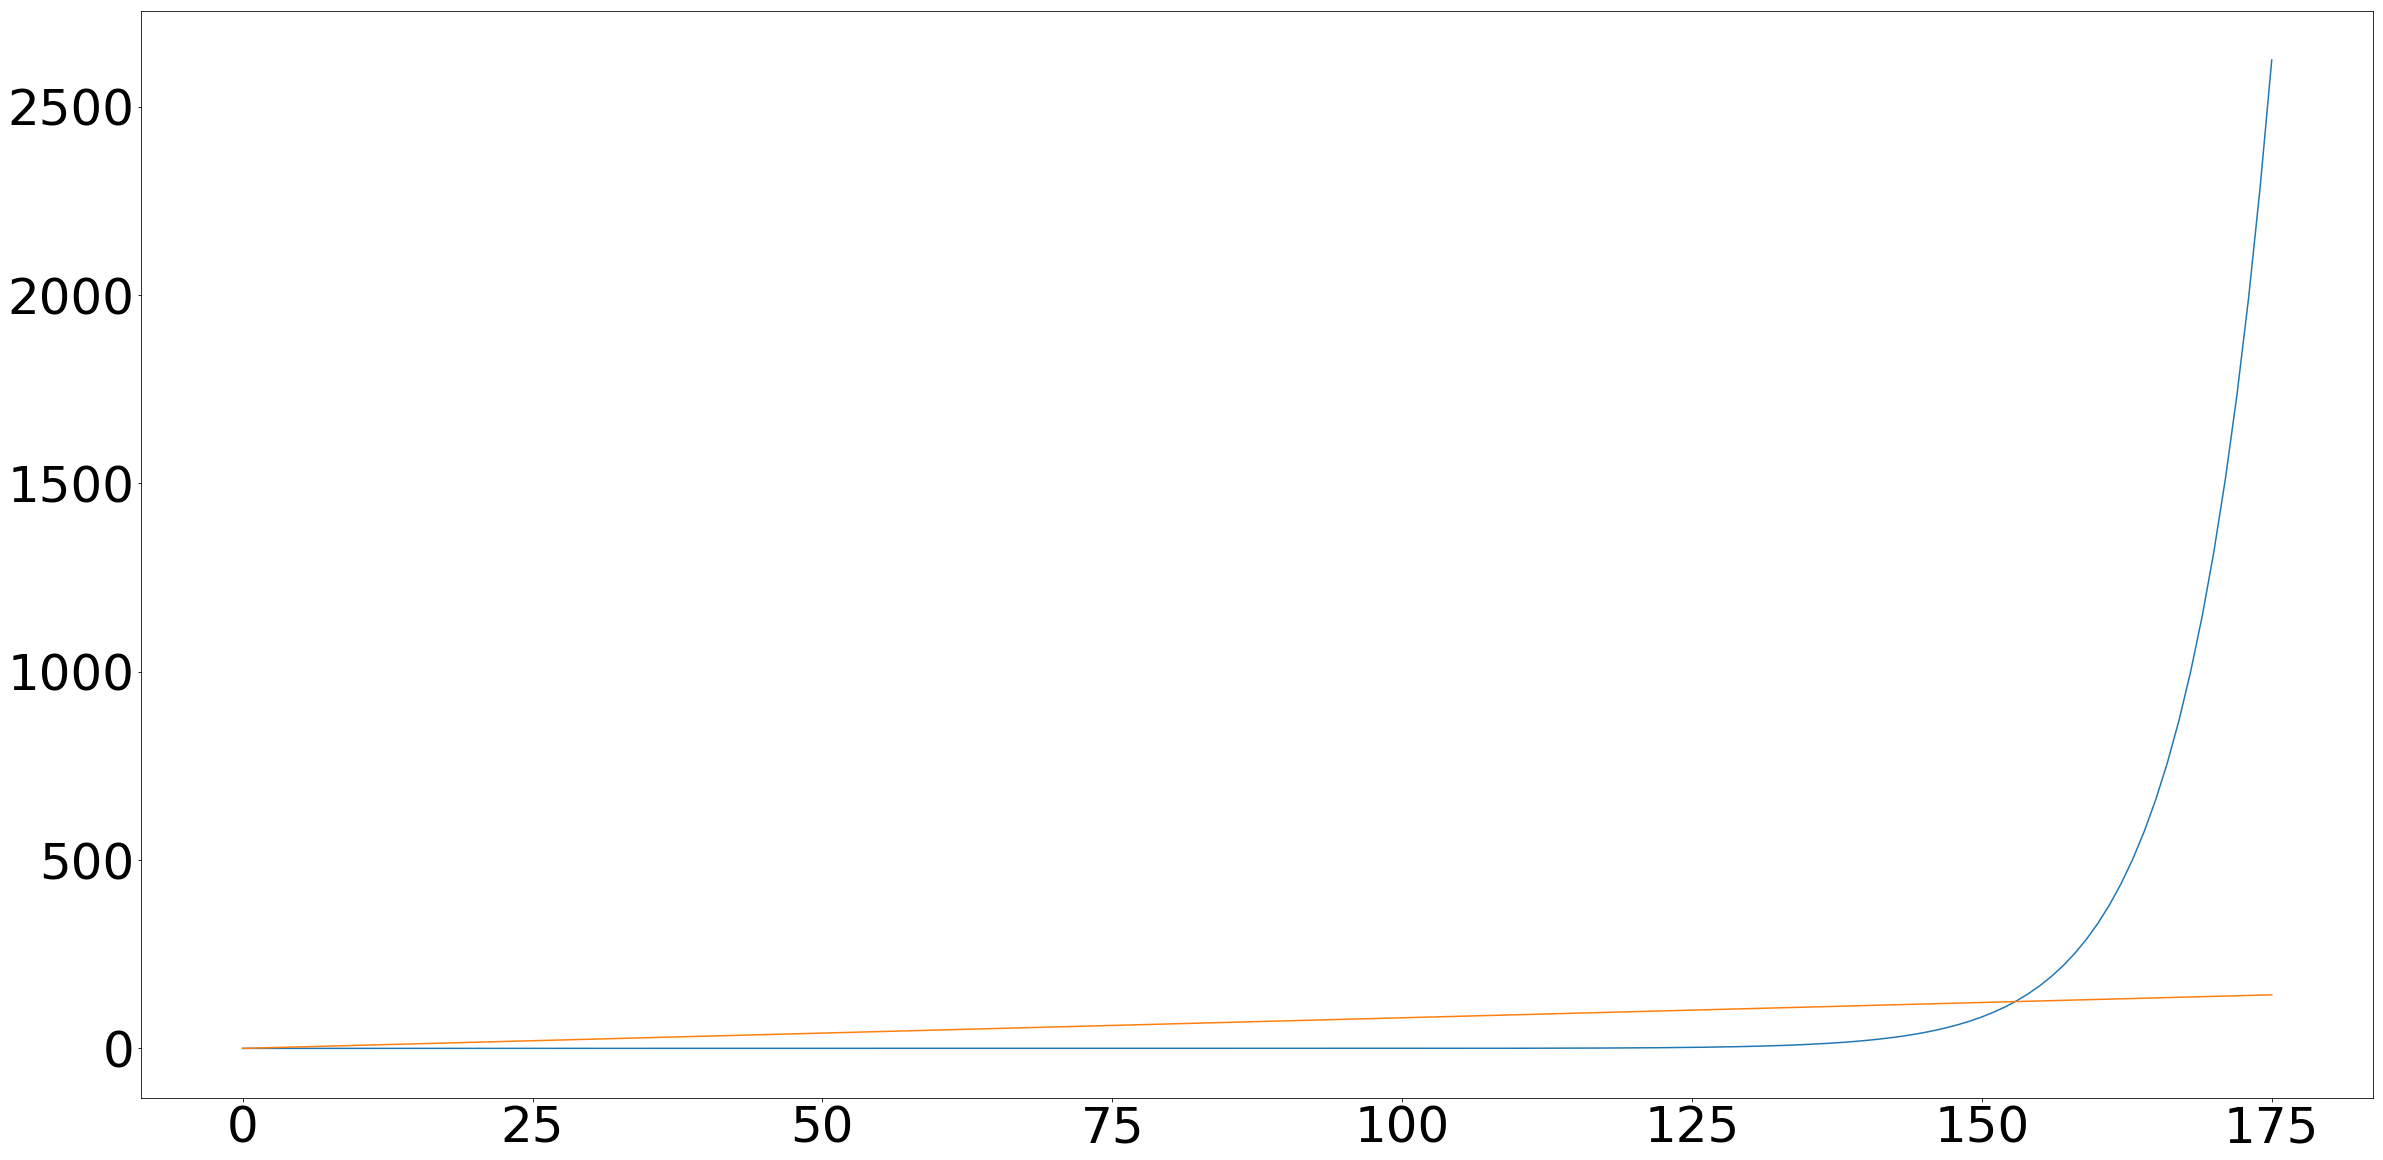

In [27]:
x   = np.linspace(0,175,176)
y   = a*np.exp(b*x) 
y_2 = (13/16)*x

fig = plt.figure(figsize=(40, 20))
new_xticks = np.linspace(0, 175, 176)

plt.xticks(fontsize=50)
plt.yticks(fontsize=50)
plt.plot(x, y)
plt.plot(x, y_2)
# plt.savefig("estimate_runtime_2.png", dpi=300)
plt.show()

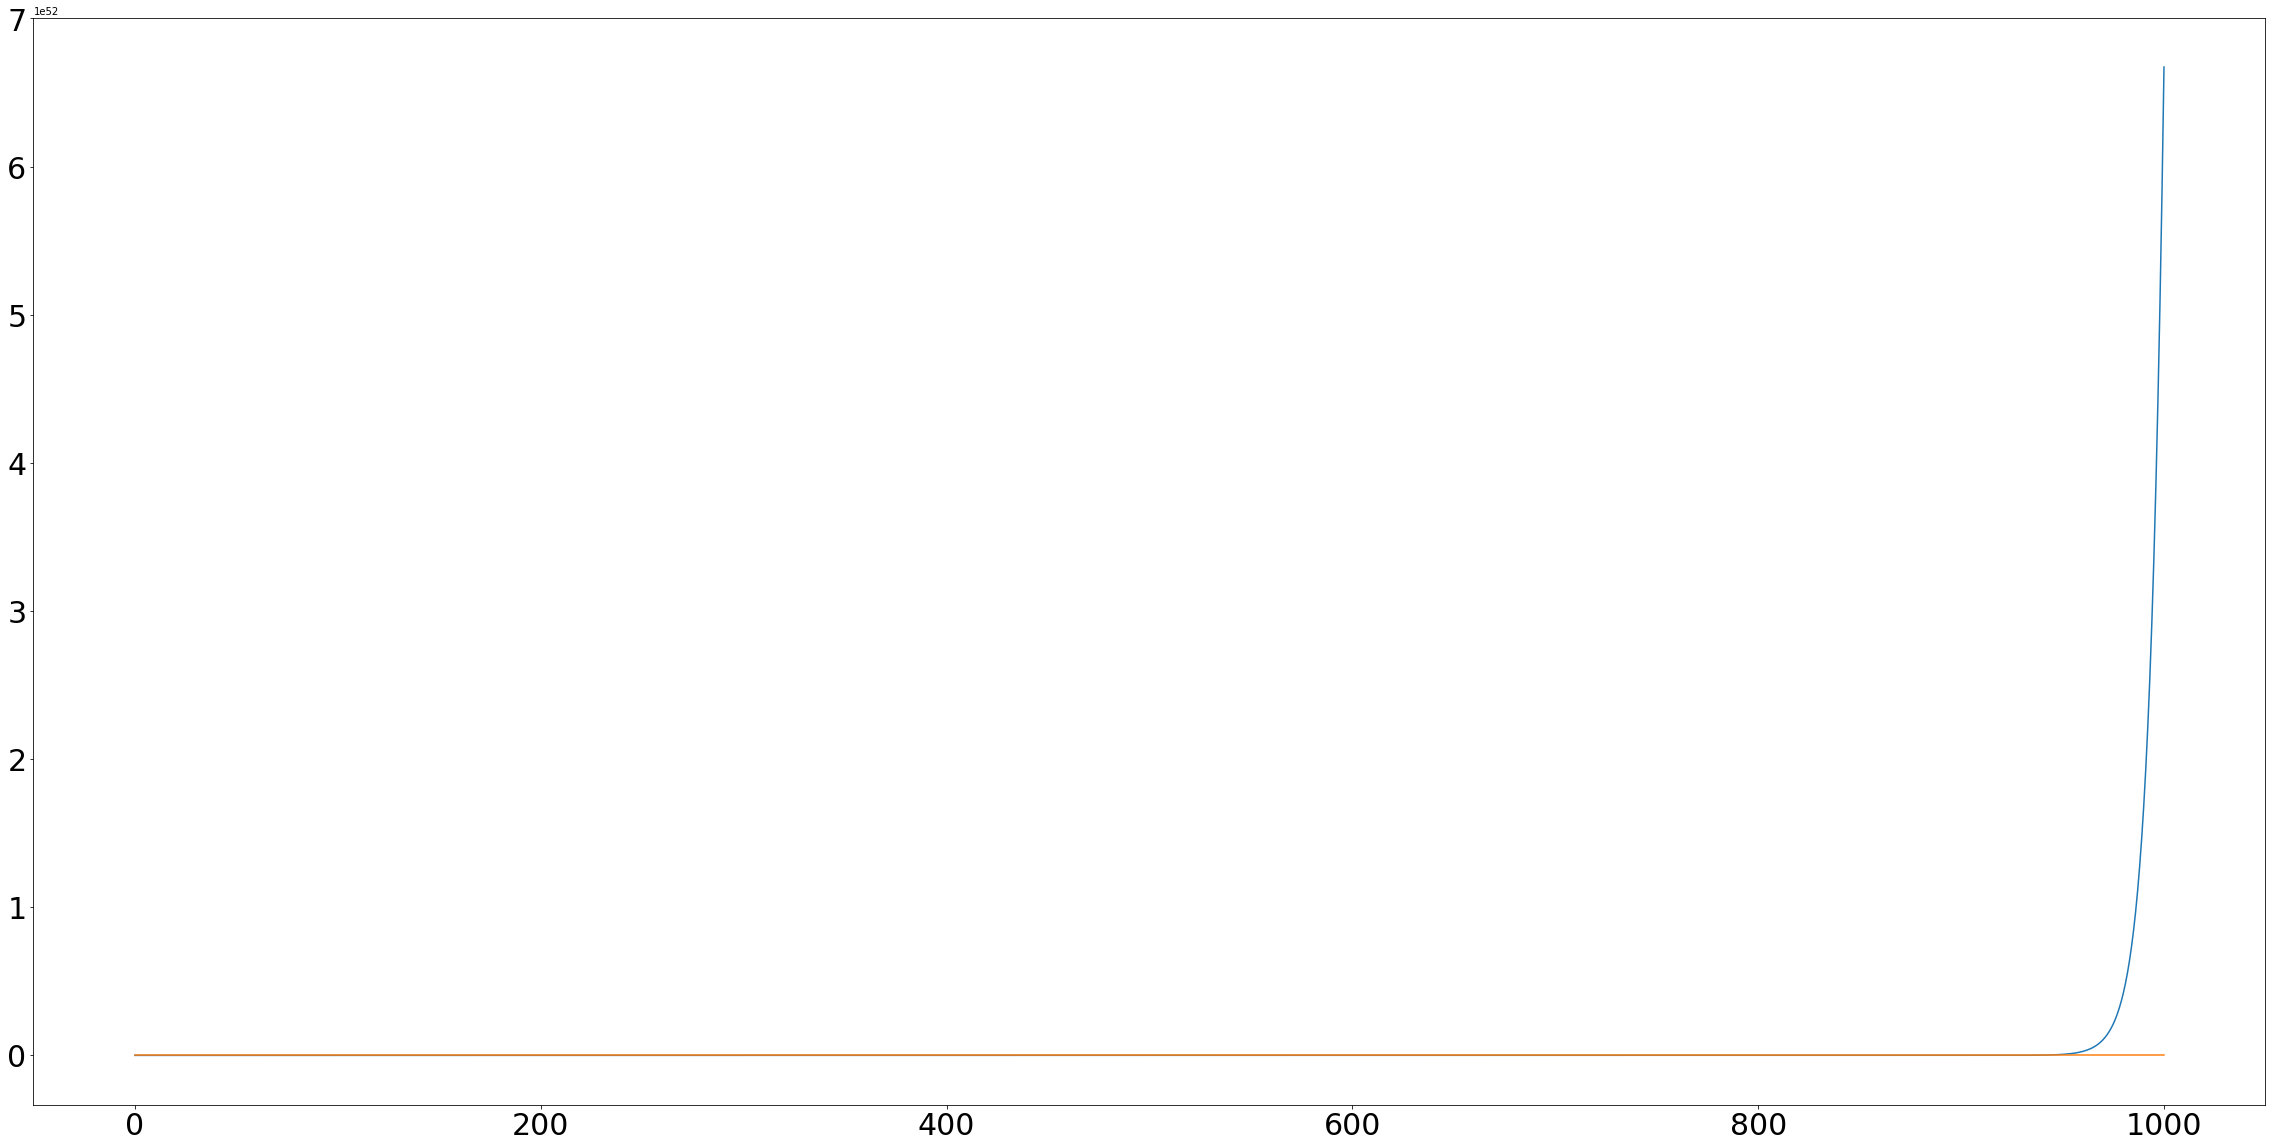

In [28]:
x   = np.linspace(0,1000,1001)
y   = a*np.exp(b*x) 
y_2 = (13/16)*x

fig = plt.figure(figsize=(40, 20))
new_xticks = np.linspace(0, 1000, 1001)

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.plot(x, y)
plt.plot(x, y_2)
# plt.savefig("estimate_runtime_1000.png", dpi=300)
plt.show()

### Plot

In [29]:
DF_solution.set_index([list(range(120, 168))], inplace=True, drop=True)
DF_runtime.set_index([list(range(120, 168))], inplace=True, drop=True)

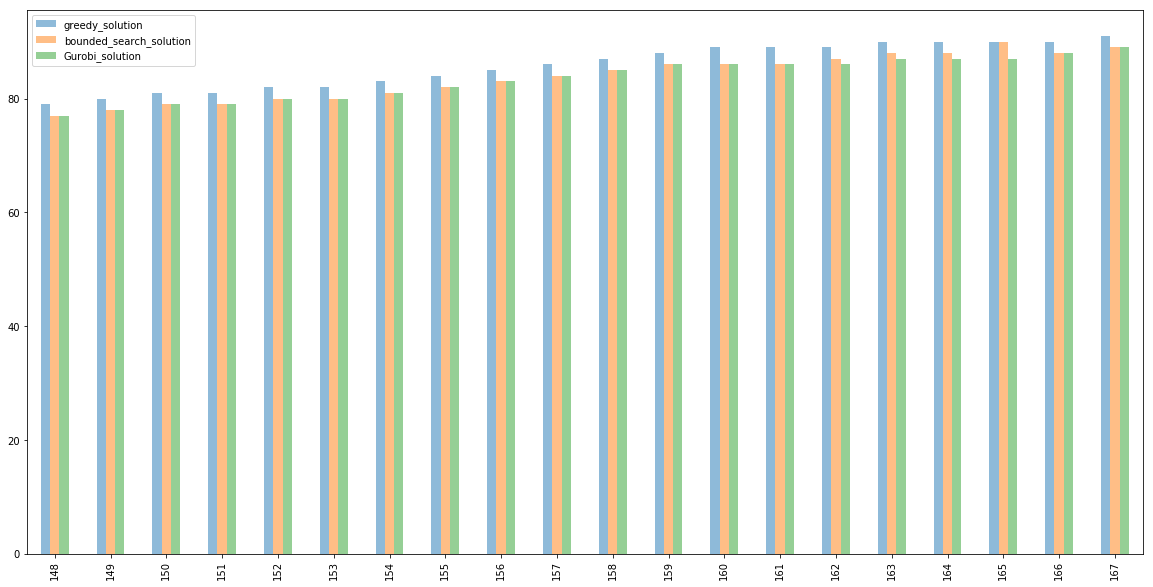

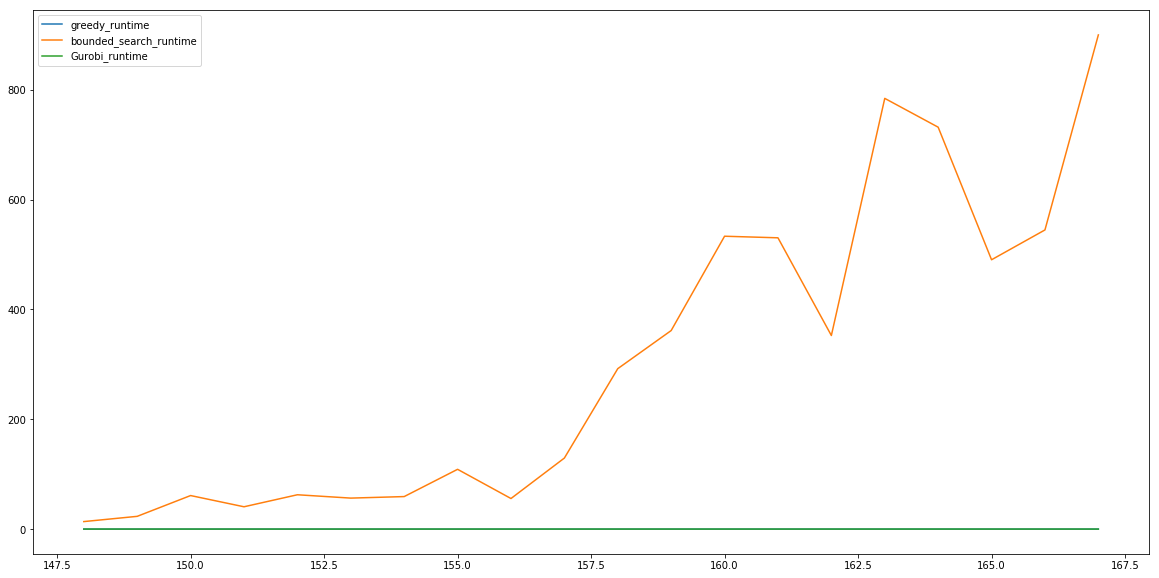

In [65]:
DF_solution[-20:].plot(kind='bar', figsize=(20,10), alpha=0.5)
# plt.savefig("compare1", dpi=300)
DF_runtime[-20:].plot(kind='line', figsize=(20,10))
# plt.savefig("compare2", dpi=300)

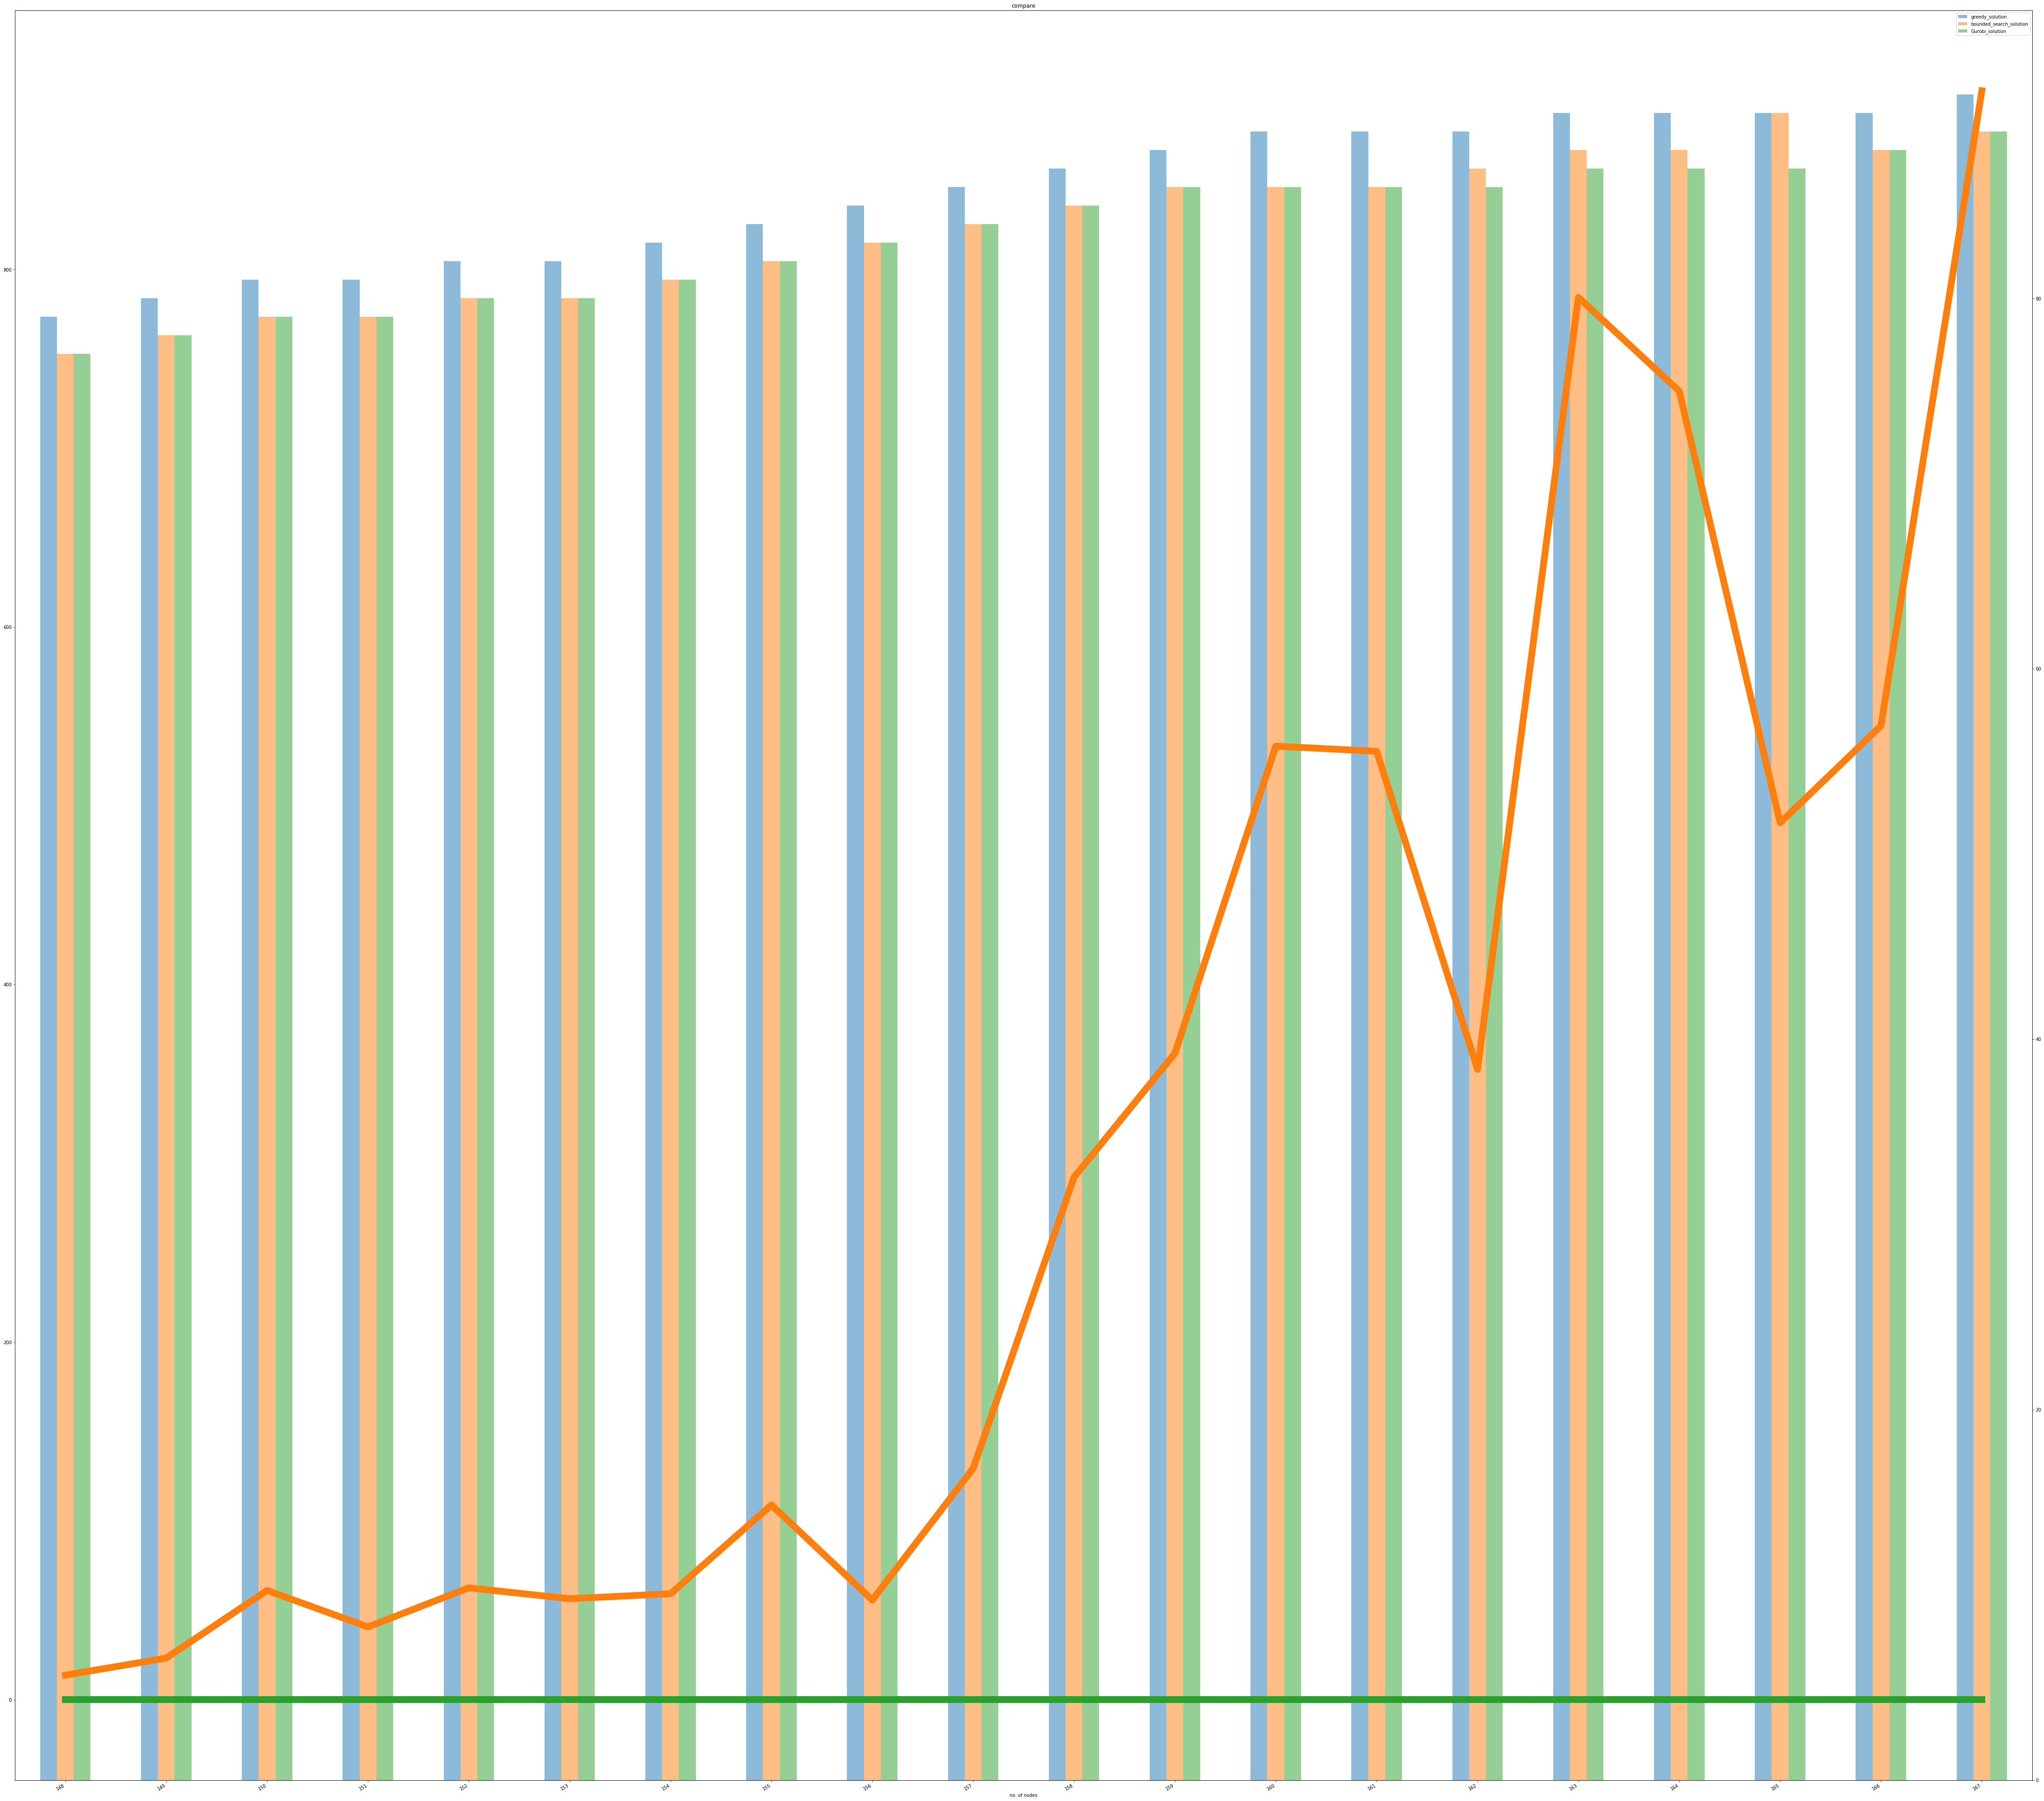

In [73]:
fig, ax = plt.subplots()

DF_all[-20:][['greedy_solution', 'bounded_search_solution', 'Gurobi_solution']].plot(kind='bar', stacked=False, title='compare', 
                                                                               ax=ax, grid=False, alpha=0.5)
ax2 = ax.twinx()
ax2.plot(ax.get_xticks(), DF_all[-20:][['greedy_runtime', 'bounded_search_runtime', 'Gurobi_runtime']].values, 
         linestyle='-', marker='o', linewidth=15)

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='best')
ax.yaxis.set_ticks_position("right")
ax2.yaxis.set_ticks_position("left")

fig.autofmt_xdate()
# plt.savefig("combine", dpi=100)
plt.show()

### compare

In [113]:
# ---------------This will take a lot of time--------------- 
series = list(range(140, 240, 20))

In [114]:
DF_solution_ER, DF_runtime_ER = Data_series_ER(series)

greedy search finished
runtime = 0.008000612258911133
	
two approximate finished
runtime = 0.0
	
two minus approximate finished
runtime = 0.014000892639160156
	
Bounded Search finished
runtime = 280.0760192871094
	
Optimize a model with 765 rows, 140 columns and 1530 nonzeros
Variable types: 0 continuous, 140 integer (140 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 111.0000000
Presolve removed 260 rows and 0 columns
Presolve time: 0.00s
Presolved: 505 rows, 140 columns, 1195 nonzeros
Variable types: 0 continuous, 140 integer (140 binary)

Root relaxation: objective 8.913057e+01, 390 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   89.13057    0  139  111.00000   89.13057  19.7%     -    0

H  165    86                     116.0000000  107.18819  7.60%  66.9    0s
 12573  1837  113.80645   31  105  116.00000  112.66154  2.88%  42.9    5s

Explored 20274 nodes (801829 simplex iterations) in 6.38 seconds
Thread count was 8 (of 8 available processors)

Solution count 8: 116 117 118 ... 131

Optimal solution found (tolerance 1.00e-04)
Best objective 1.160000000000e+02, best bound 1.160000000000e+02, gap 0.0000%
runtime = 6.404366493225098
	
greedy search finished
runtime = 0.013000726699829102
	
two approximate finished
runtime = 0.0009999275207519531
	
two minus approximate finished
runtime = 0.022001266479492188
	
Bounded Search finished
runtime = 360.1586000919342
	
Optimize a model with 1281 rows, 180 columns and 2562 nonzeros
Variable types: 0 continuous, 180 integer (180 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objectiv

     0     0  134.39266    0  198  155.00000  134.39266  13.3%     -    0s
     0     0  134.55106    0  199  155.00000  134.55106  13.2%     -    0s
     0     0  134.55407    0  199  155.00000  134.55407  13.2%     -    0s
     0     0  134.74180    0  199  155.00000  134.74180  13.1%     -    0s
     0     0  134.76871    0  200  155.00000  134.76871  13.1%     -    0s
     0     0  134.77086    0  200  155.00000  134.77086  13.1%     -    0s
     0     0  134.77129    0  200  155.00000  134.77129  13.1%     -    0s
     0     0  135.01308    0  198  155.00000  135.01308  12.9%     -    0s
     0     0  135.01308    0  198  155.00000  135.01308  12.9%     -    0s
     0     0  135.22057    0  199  155.00000  135.22057  12.8%     -    0s
     0     0  135.29241    0  198  155.00000  135.29241  12.7%     -    0s
     0     0  135.30091    0  198  155.00000  135.30091  12.7%     -    0s
     0     0  135.30102    0  198  155.00000  135.30102  12.7%     -    0s
     0     0  135.41760  

 509279 180211  150.91071   39   99  154.00000  149.37195  3.01%  65.3  320s
 521756 183040  152.03390   45  119  154.00000  149.40563  2.98%  65.1  325s
 530978 184991  151.37975   46  106  154.00000  149.43106  2.97%  64.9  330s
 543595 187786     cutoff   47       154.00000  149.46667  2.94%  64.7  335s
 556311 190510  152.33651   39  121  154.00000  149.50000  2.92%  64.5  340s
 569588 193301  151.53975   47  117  154.00000  149.53333  2.90%  64.3  345s
 578438 195022  151.55435   49  120  154.00000  149.55442  2.89%  64.2  350s
 590971 197590  151.85714   40  108  154.00000  149.58472  2.87%  64.0  355s
 604493 200230  152.42029   36  104  154.00000  149.61759  2.85%  63.8  360s
 616972 202656  150.98167   51  121  154.00000  149.64647  2.83%  63.6  365s
 627055 204515  151.90625   41  104  154.00000  149.67030  2.81%  63.5  370s
 639666 206884  151.40925   46  113  154.00000  149.70112  2.79%  63.3  375s
 649286 208597  152.50000   40   81  154.00000  149.72165  2.78%  63.2  380s

 1942516 204425     cutoff   41       154.00000  151.49425  1.63%  53.6  850s
 1959771 201366  152.38462   44   96  154.00000  151.50000  1.62%  53.4  855s
 1973099 198813  152.81250   58   95  154.00000  151.50769  1.62%  53.4  860s
 1988377 195634  152.28070   43  109  154.00000  151.52857  1.60%  53.3  865s
 2001155 192765  151.58750   47   98  154.00000  151.54545  1.59%  53.3  870s
 2015914 189583     cutoff   42       154.00000  151.56311  1.58%  53.2  875s
 2029071 186691     cutoff   51       154.00000  151.57917  1.57%  53.2  880s
 2041902 183541  153.00000   46  106  154.00000  151.59672  1.56%  53.1  885s
 2057377 179755  153.00000   47   78  154.00000  151.61538  1.55%  53.0  890s
 2070160 176435  152.41935   47  107  154.00000  151.63095  1.54%  53.0  895s
 2085651 172441  152.80000   53  104  154.00000  151.65129  1.53%  52.9  900s
*2094641 87055              34     153.0000000  151.66532  0.87%  52.9  903s
 2100606 81683     cutoff   52       153.00000  151.68270  0.86% 

 251771 152984  168.16625   48  136  173.00000  163.24253  5.64%  79.2  195s
 257130 156298  165.89748   47  145  173.00000  163.27690  5.62%  79.0  200s
 260536 158466  169.35426   46  124  173.00000  163.29939  5.61%  78.9  205s
 270172 164559  167.35790   43  136  173.00000  163.36134  5.57%  78.6  210s
 278907 170092  165.65517   39  131  173.00000  163.41784  5.54%  78.3  215s
 289659 176825  165.80928   44  145  173.00000  163.48042  5.50%  77.9  220s
 300349 183587  168.61862   47  125  173.00000  163.54131  5.47%  77.6  225s
 308235 188426  169.63158   47  128  173.00000  163.58748  5.44%  77.4  230s
 318455 194794  165.80920   35  133  173.00000  163.63904  5.41%  77.1  235s
 329372 201586  166.45493   40  140  173.00000  163.69318  5.38%  76.8  240s
 339459 207798  167.22857   36  129  173.00000  163.74490  5.35%  76.5  245s
 350560 214646  168.12658   42  136  173.00000  163.79282  5.32%  76.2  250s
 361675 221413     cutoff   56       173.00000  163.84234  5.29%  76.0  255s

 1463735 799488  168.00000   43   90  173.00000  166.00108  4.05%  64.1  725s
 1477283 805791  169.65495   47  111  173.00000  166.01662  4.04%  64.1  730s
 1490541 811915     cutoff   41       173.00000  166.03027  4.03%  64.0  735s
 1502587 817515  169.12500   42   96  173.00000  166.04208  4.02%  63.9  740s
 1517083 824175  171.58605   52  111  173.00000  166.05739  4.01%  63.9  745s
 1530433 830332     cutoff   52       173.00000  166.07083  4.01%  63.8  750s
 1544618 836882  167.76000   42  129  173.00000  166.08456  4.00%  63.7  755s
 1553958 841148     cutoff   60       173.00000  166.09360  3.99%  63.7  760s
 1568496 847862  171.92763   41  100  173.00000  166.10732  3.98%  63.6  765s
 1579992 853127     cutoff   49       173.00000  166.11854  3.98%  63.6  770s
 1594367 859867  169.30192   47  126  173.00000  166.13208  3.97%  63.5  775s
 1607594 865959  170.07558   47  118  173.00000  166.14432  3.96%  63.4  780s
 1618216 870762  167.81265   61  137  173.00000  166.15480  3.96

 2869810 1387227  171.87879   51  103  173.00000  167.00000  3.47%  58.9 1255s
 2885243 1393007  171.89116   46  103  173.00000  167.00621  3.46%  58.9 1260s
 2894947 1396637  169.66035   49  124  173.00000  167.01235  3.46%  58.8 1265s
 2908813 1401819  171.53571   47  114  173.00000  167.02027  3.46%  58.8 1270s
 2923355 1407300     cutoff   60       173.00000  167.02818  3.45%  58.8 1275s
 2937763 1412658  170.97240   70  129  173.00000  167.03593  3.45%  58.7 1280s
 2950145 1417289     cutoff   49       173.00000  167.04231  3.44%  58.7 1285s
 2964216 1422529  170.33333   44  103  173.00000  167.04967  3.44%  58.7 1290s
 2978591 1427900  169.59259   52  121  173.00000  167.05687  3.44%  58.6 1295s
 2992628 1433102  167.52113   62  134  173.00000  167.06414  3.43%  58.6 1301s
 3002430 1436704     cutoff   43       173.00000  167.06970  3.43%  58.6 1305s
 3017970 1442348  169.45000   48  127  173.00000  167.07714  3.42%  58.5 1310s
 3033207 1447963     cutoff   54       173.00000  16

 4370586 1897253  170.95192   51  114  173.00000  167.62500  3.11%  55.8 1775s
 4386574 1902203  169.74278   60  129  173.00000  167.62963  3.10%  55.8 1780s
 4400051 1906284  171.32700   77  126  173.00000  167.63452  3.10%  55.8 1785s
 4417258 1911467  171.66667   53  103  173.00000  167.64023  3.10%  55.7 1790s
 4429103 1915083  169.54073   53  124  173.00000  167.64413  3.10%  55.7 1795s
 4445334 1920053  170.78070   47  112  173.00000  167.65013  3.09%  55.7 1800s
 4461474 1925060     cutoff   55       173.00000  167.65602  3.09%  55.7 1805s
 4471237 1927962  172.00000   52   82  173.00000  167.65940  3.09%  55.7 1810s
 4487590 1932964     cutoff   53       173.00000  167.66596  3.08%  55.6 1815s
 4506280 1938441  171.17241   49  108  173.00000  167.66667  3.08%  55.6 1820s
 4521921 1943185     cutoff   49       173.00000  167.67308  3.08%  55.6 1825s
 4538078 1948096  170.02212   40  115  173.00000  167.67883  3.08%  55.6 1830s
 4550863 1951995  169.43544   49  122  173.00000  16

 5915170 1981023  170.45455   51  117  172.00000  168.12500  2.25%  53.8 2290s
 5932135 1982396     cutoff   53       172.00000  168.13043  2.25%  53.8 2295s
 5945789 1983468  169.74074   39  105  172.00000  168.13599  2.25%  53.8 2300s
 5961214 1984609  169.63250   47  118  172.00000  168.14227  2.24%  53.7 2305s
 5976210 1985802  169.04029   58  125  172.00000  168.14703  2.24%  53.7 2310s
 5987217 1986569  169.47907   39  109  172.00000  168.15152  2.24%  53.7 2315s
 6003623 1987657  171.00000   44   72  172.00000  168.15789  2.23%  53.7 2320s
 6019624 1988828  170.75000   39   91  172.00000  168.16416  2.23%  53.7 2325s
 6034225 1989851  170.50000   40   83  172.00000  168.16667  2.23%  53.7 2330s
 6050451 1990953     cutoff   63       172.00000  168.17365  2.22%  53.7 2335s
 6062325 1991732  171.00000   50   82  172.00000  168.17849  2.22%  53.7 2340s
 6079630 1992905     cutoff   56       172.00000  168.18487  2.22%  53.6 2345s
 6091015 1993570  169.59799   63  117  172.00000  16

 7504847 2023270  169.22727   40  116  172.00000  168.65618  1.94%  52.4 2810s
 7518180 2022902  170.63158   45  108  172.00000  168.66128  1.94%  52.4 2815s
 7536106 2022554  170.30612   50  111  172.00000  168.66667  1.94%  52.4 2820s
 7555903 2022216     cutoff   66       172.00000  168.66667  1.94%  52.4 2825s
 7569474 2021917  170.66667   48  111  172.00000  168.67143  1.94%  52.4 2830s
 7582201 2021384  170.68098   54  114  172.00000  168.67619  1.93%  52.3 2835s
 7598043 2020939  170.81250   40  106  172.00000  168.68182  1.93%  52.3 2840s
 7614933 2020438  170.47581   43  108  172.00000  168.68750  1.93%  52.3 2845s
 7627903 2020184     cutoff   60       172.00000  168.69186  1.92%  52.3 2850s
 7643399 2019544  169.00945   50  118  172.00000  168.69681  1.92%  52.3 2855s
 7661632 2019084     cutoff   47       172.00000  168.70149  1.92%  52.3 2860s
 7675507 2018606  169.76106   52  115  172.00000  168.70644  1.91%  52.3 2865s
 7692094 2017914  170.26596   55  118  172.00000  16

 9114161 1900458     cutoff   50       172.00000  169.11494  1.68%  51.2 3330s
 9130028 1898341     cutoff   61       172.00000  169.12000  1.67%  51.2 3335s
 9143518 1896545     cutoff   44       172.00000  169.12500  1.67%  51.2 3340s
 9158823 1894587     cutoff   55       172.00000  169.12683  1.67%  51.2 3345s
 9174874 1892272     cutoff   51       172.00000  169.13294  1.67%  51.2 3350s
 9188414 1890422  170.25000   42  100  172.00000  169.13671  1.66%  51.1 3355s
 9204672 1888189     cutoff   58       172.00000  169.14286  1.66%  51.1 3360s
 9219915 1886205  170.00000   45   80  172.00000  169.14583  1.66%  51.1 3365s
 9233963 1884080  169.88406   38  106  172.00000  169.15000  1.66%  51.1 3370s
 9248533 1882073  170.21818   58  120  172.00000  169.15498  1.65%  51.1 3375s
 9263163 1879723  169.72247   43  119  172.00000  169.16000  1.65%  51.1 3380s
 9279100 1877384     cutoff   44       172.00000  169.16667  1.65%  51.1 3385s
 9296940 1874880     cutoff   53       172.00000  16

 10662684 1589255  169.61364   48  122  172.00000  169.54483  1.43%  50.1 3850s
 10675284 1585813  170.51852   45  102  172.00000  169.54815  1.43%  50.1 3855s
 10691142 1581335     cutoff   48       172.00000  169.55393  1.42%  50.1 3860s
 10707756 1576715     cutoff   61       172.00000  169.55814  1.42%  50.1 3865s
 10718384 1573648  170.28000   42  105  172.00000  169.56250  1.42%  50.1 3870s
 10734268 1569130  170.16463   56  110  172.00000  169.56716  1.41%  50.1 3875s
 10751866 1564135  170.34000   50  106  172.00000  169.57143  1.41%  50.1 3880s
 10767645 1559653     cutoff   48       172.00000  169.57692  1.41%  50.1 3885s
 10782842 1555231  170.83117   50  114  172.00000  169.58290  1.41%  50.0 3890s
 10799263 1550446  170.33146   44  110  172.00000  169.58696  1.40%  50.0 3895s
 10815312 1545765     cutoff   38       172.00000  169.59259  1.40%  50.0 3900s
 10827959 1541883  170.60526   47  100  172.00000  169.59756  1.40%  50.0 3905s
 10845493 1536869     cutoff   59       

 12249990 977963  170.75000   45  100  172.00000  170.03448  1.14%  49.0 4365s
 12265351 969760     cutoff   54       172.00000  170.04255  1.14%  48.9 4370s
 12283170 960325     cutoff   47       172.00000  170.05156  1.13%  48.9 4375s
 12298383 952265     cutoff   40       172.00000  170.05882  1.13%  48.9 4380s
 12316024 942631  170.75000   59  105  172.00000  170.06734  1.12%  48.9 4385s
 12331769 933991  170.92727   52  103  172.00000  170.07527  1.12%  48.9 4390s
 12346456 926030  170.58599   48  109  172.00000  170.08333  1.11%  48.9 4395s
 12361523 917618     cutoff   50       172.00000  170.08989  1.11%  48.8 4400s
 12379681 907279  170.56777   57  115  172.00000  170.10000  1.10%  48.8 4405s
 12396226 898001  170.83333   61   98  172.00000  170.10606  1.10%  48.8 4410s
 12410713 889960     cutoff   53       172.00000  170.11207  1.10%  48.8 4415s
 12428619 879452     cutoff   47       172.00000  170.12346  1.09%  48.8 4420s
 12447475 868793  170.62295   57  101  172.00000  17

In [117]:
DF_solution_BA, DF_runtime_BA = Data_series_BA(series)

greedy search finished
runtime = 0.008000612258911133
	
two approximate finished
runtime = 0.0009999275207519531
	
two minus approximate finished
runtime = 0.012000799179077148
	
Bounded Search finished
runtime = 12.818733215332031
	
Optimize a model with 544 rows, 140 columns and 1088 nonzeros
Variable types: 0 continuous, 140 integer (140 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 97.0000000
Presolve removed 193 rows and 2 columns
Presolve time: 0.00s
Presolved: 351 rows, 138 columns, 832 nonzeros
Found heuristic solution: objective 96.0000000
Variable types: 0 continuous, 138 integer (138 binary)

Root relaxation: objective 7.400000e+01, 159 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0   

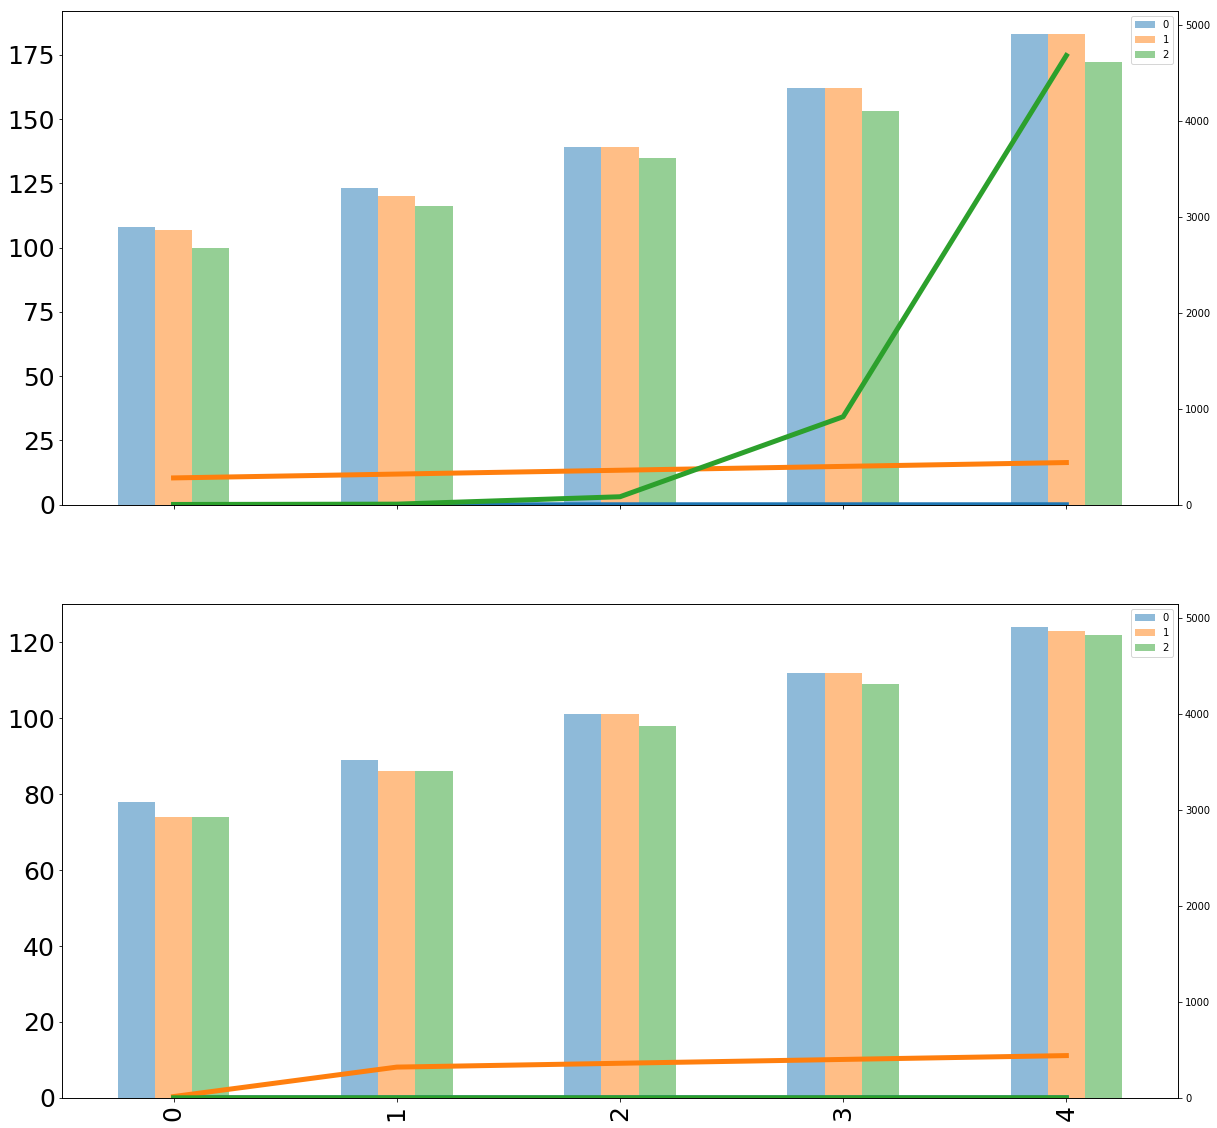

In [120]:
fig, (axER, axBA) = plt.subplots(2, 1, figsize=(20, 20))
tmax_ER = max(DF_runtime_ER.values.max(), DF_runtime_BA.values.max()) * 1.1

DF_runtime_ER.plot(kind='line', ax=axER.twinx(), ylim=(-0.1, tmax_ER), linewidth=5, ls='-', legend=False)
DF_solution_ER.plot(kind='bar', ax=axER, alpha=0.5, fontsize=25)
DF_runtime_BA.plot(kind='line', ax=axBA.twinx(), ylim=(-0.1, tmax_ER), linewidth=5, ls='-', legend=False)
DF_solution_BA.plot(kind='bar', ax=axBA, alpha=0.5, fontsize=25);
plt.savefig("1230", dpi=300)